In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load engineered vaccine uptake dataset
df = pd.read_csv("data/final_X_y_smoothed_wcovid_vaccinated.csv")

# Use geo_value later for regional mapping
geo_col = df['geo_value']

# Behavioral + belief features for clustering
cluster_features = [
    'smoothed_wwearing_mask',
    'smoothed_wwork_outside_home_1d',
    'smoothed_wlarge_event_1d',
    'smoothed_wrestaurant_1d',
    'smoothed_wshop_1d',
    'smoothed_wpublic_transit_1d',
    'smoothed_wspent_time_1d',
    'smoothed_wworried_become_ill',
    'smoothed_wvaccine_likely_friends',
    'smoothed_wvaccine_likely_politicians',
    'smoothed_wvaccine_likely_who'
]

df_cluster = df[cluster_features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

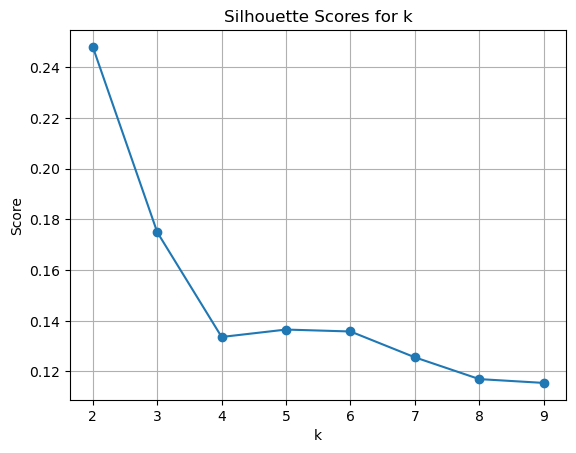

In [3]:
# Silhouette method
sil_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.plot(range(2, 10), sil_scores, marker='o')
plt.title("Silhouette Scores for k")
plt.xlabel("k")
plt.ylabel("Score")
plt.grid(True)
plt.show()

In [8]:
# Fit final model (e.g. k=3 based on previous elbow & silhouette)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
df['cluster'] = kmeans.fit_predict(X_scaled)

# Preview cluster sizes
df['cluster'].value_counts()

cluster
1    9272
2    9042
0    3872
3    3440
Name: count, dtype: int64

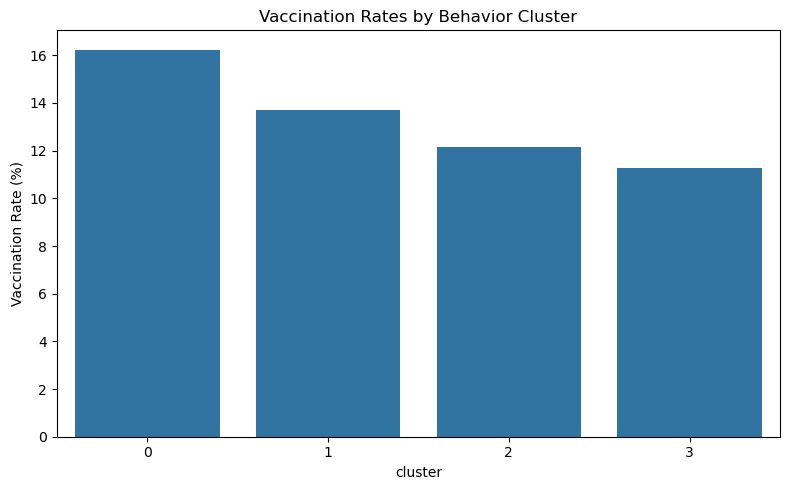

In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='cluster', y='smoothed_wcovid_vaccinated', errorbar=None)
plt.title("Vaccination Rates by Behavior Cluster")
plt.ylabel("Vaccination Rate (%)")
plt.tight_layout()
plt.show()

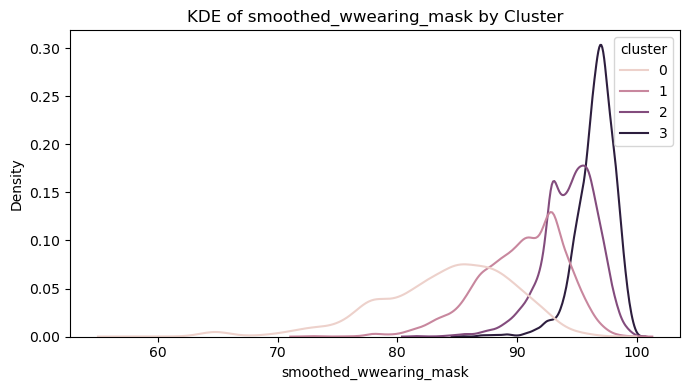

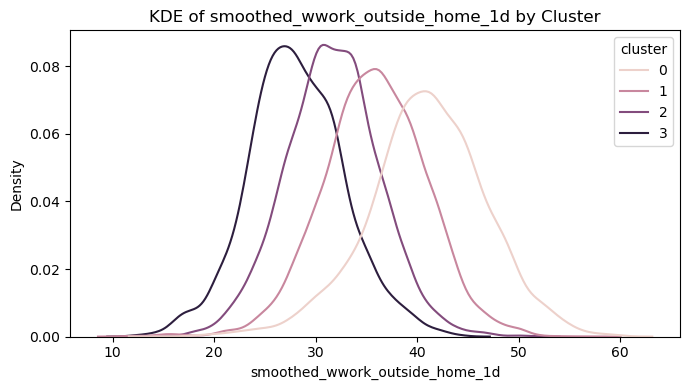

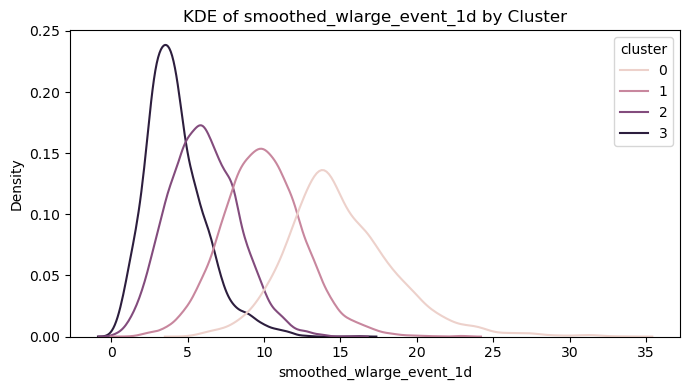

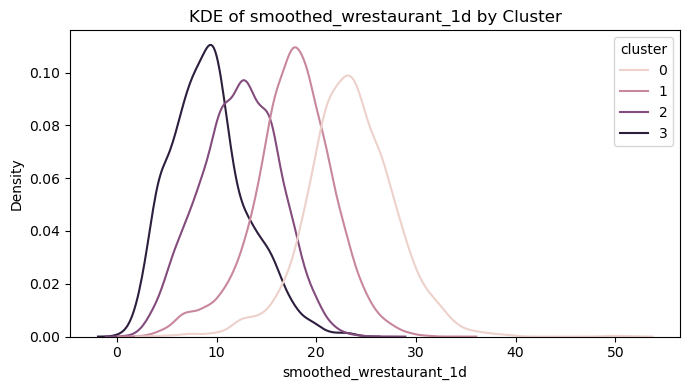

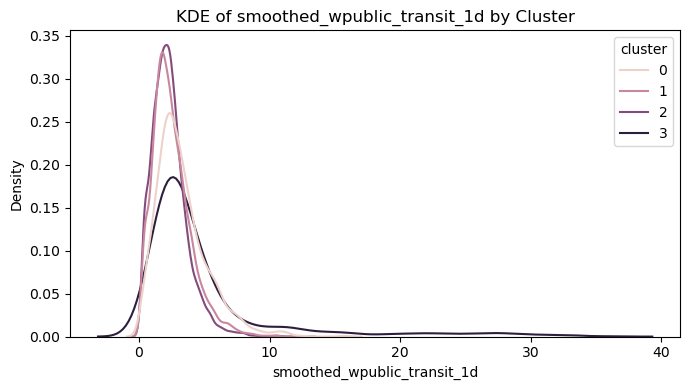

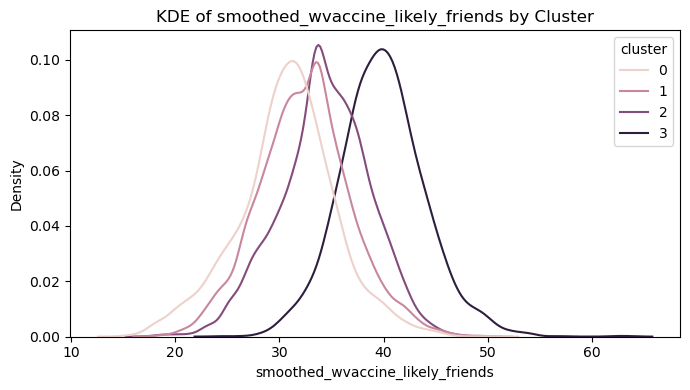

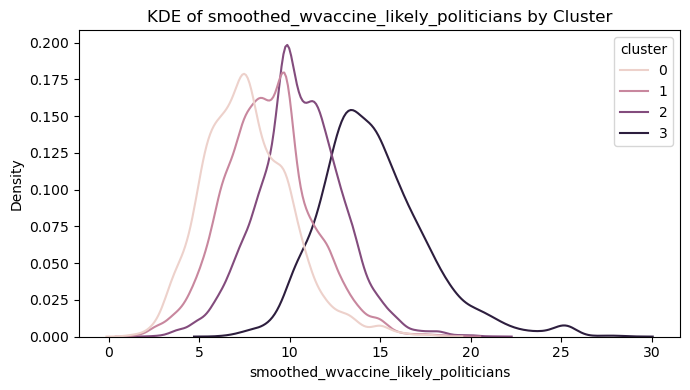

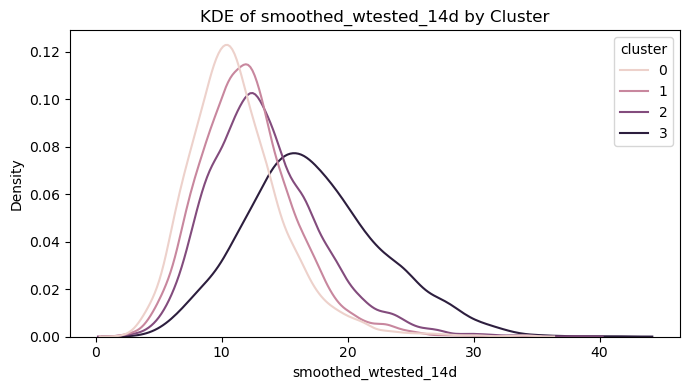

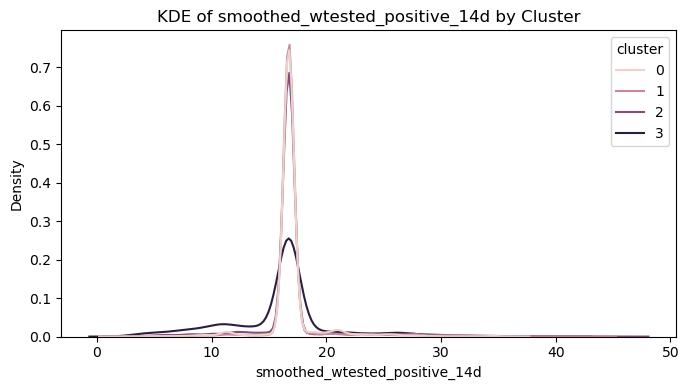

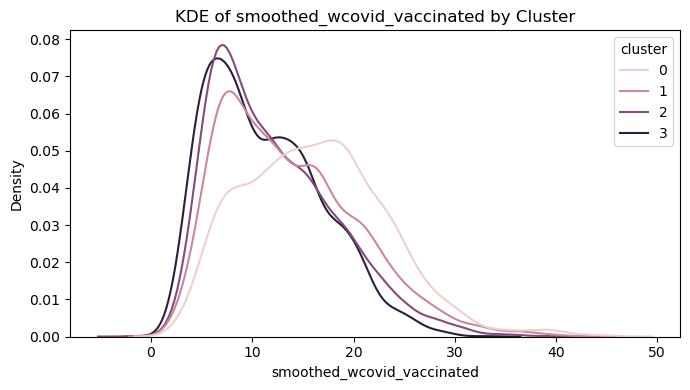

In [19]:
cluster_features = [
    'smoothed_wwearing_mask', 'smoothed_wwork_outside_home_1d',
    'smoothed_wlarge_event_1d', 'smoothed_wrestaurant_1d',
    'smoothed_wpublic_transit_1d', 'smoothed_wvaccine_likely_friends',
    'smoothed_wvaccine_likely_politicians', 'smoothed_wtested_14d',
    'smoothed_wtested_positive_14d', 'smoothed_wcovid_vaccinated'
]

for var in cluster_features:
    plt.figure(figsize=(7, 4))
    sns.kdeplot(data=df, x=var, hue="cluster", common_norm=False)
    plt.title(f"KDE of {var} by Cluster")
    plt.tight_layout()
    plt.show()

In [20]:
df.groupby("cluster")[cluster_features].mean().T

cluster,0,1,2,3
smoothed_wwearing_mask,84.076818,90.405781,94.380751,96.570746
smoothed_wwork_outside_home_1d,40.925507,35.780931,31.640167,28.114214
smoothed_wlarge_event_1d,14.991891,9.915403,6.044811,4.224319
smoothed_wrestaurant_1d,23.423751,17.570327,12.280654,9.269350
smoothed_wpublic_transit_1d,3.283434,2.533651,2.337135,4.891566
smoothed_wvaccine_likely_friends,30.739087,32.453443,34.330006,39.916870
smoothed_wvaccine_likely_politicians,7.667026,8.812089,10.528836,14.638634
smoothed_wtested_14d,11.195284,12.075831,13.427473,17.281109
smoothed_wtested_positive_14d,16.953394,17.191350,16.775490,16.047461
smoothed_wcovid_vaccinated,16.235659,13.686339,12.173281,11.274088


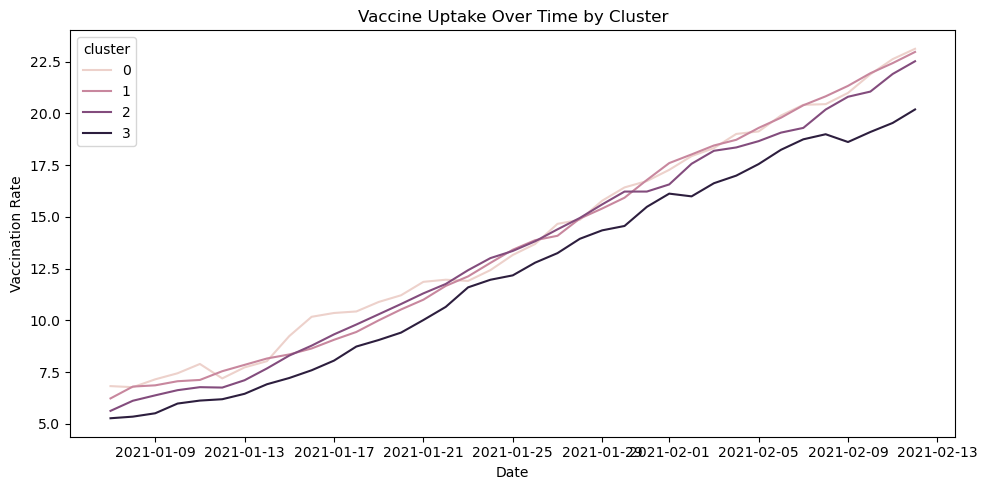

In [14]:
df['time_value'] = pd.to_datetime(df['time_value'])
df_trend = df.groupby(['time_value', 'cluster'])['smoothed_wcovid_vaccinated'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_trend, x='time_value', y='smoothed_wcovid_vaccinated', hue='cluster')
plt.title("Vaccine Uptake Over Time by Cluster")
plt.ylabel("Vaccination Rate")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

## Policy Clustering Analysis with Model-Aligned Insights

We applied **KMeans clustering (k=4)** on key behavioral and perceptual features to segment U.S. counties into four distinct population groups. Each group displays a unique combination of vaccine trust, public activity, and risk perception — providing an actionable framework for targeted interventions.

---

### Cluster Distribution
- **Cluster 1**: 9,272 counties  
- **Cluster 2**: 9,042 counties  
- **Cluster 0**: 3,872 counties  
- **Cluster 3**: 3,440 counties  

---

### 💉 Vaccination Rates by Cluster
| Cluster | Avg Vaccination Rate (%) | Notes |
|---------|--------------------------|-------|
| 0       | **16.2%**                | Highest uptake, high activity |
| 1       | 13.7%                    | Mid-level engagement |
| 2       | 12.2%                    | High belief, low follow-through |
| 3       | **11.3%**                | Most cautious, lowest uptake |

---

### Cluster Profiles

| Cluster | Behavior Profile                         | Vaccine Sentiment     | Observations |
|---------|-------------------------------------------|------------------------|--------------|
| 0       | High public activity (work, events)       | Moderate trust         | Exposed but engaged |
| 1       | Average exposure                          | Average trust          | Hesitant but reachable |
| 2       | Stays home, low exposure                  | High trust             | Logistical gaps likely |
| 3       | Most cautious (mask, isolation)           | High trust in peers    | Disconnect between belief and action |

---

### Insights from Predictive Models

From our XGBoost models (Steps 03 & 04), the following features were most predictive of outcomes:

#### Vaccine Uptake (R² ≈ 0.71)
- **days_since_start** (temporal momentum)
- **vaccine acceptance intent**
- **belief in WHO**

#### COVID Positivity (R² ≈ 0.82)
- **COVID-like illness (wcli)**
- **recent positivity (smoothed_wtested_positive_14d)**
- **vaccine acceptance**

These insights validate our clustering approach: the most influential cluster-level features align with what our models identified as **key drivers** of health outcomes.

---

### Model-Aligned Policy Recommendations

| Cluster | Primary Risk | Policy Focus | Recommended Tactics |
|---------|--------------|--------------|---------------------|
| 0 – High exposure, but high uptake | Transmission risk | Maintain momentum | Transit/mobile boosters, employer mandates |
| 1 – Mixed behavior, moderate trust | Engagement hesitancy | Nudge intent → action | Peer advocates, localized messaging |
| 2 – Trustful, but passive | Access/logistics | Remove barriers | Work-hour clinics, targeted SMS alerts |
| 3 – Paradox: trust but low uptake | Systemic blocks | Structural fixes | Home visits, multilingual campaigns, trusted messengers |

---

### Strategic Next Steps

- Overlay these clusters onto maps for **geographic targeting**
- Use model predictions to identify counties where **cluster traits + predicted low uptake** overlap
- Monitor **positivity and vaccine rates** over time by cluster to guide adaptive response